In [ ]:
# flake8: noqa
# ---
# jupyter:
#   jupytext:
#     formats: ipynb,py:percent
#     text_representation:
#       extension: .py
#       format_name: percent
#       format_version: '1.3'
#       jupytext_version: 1.13.8
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# Example: Oscillator

In [6]:
# Simple plotting of forward-model with a single response and parameters
from matplotlib import pyplot as plt


def plot_result(
    A, response_x_axis, trans_func=lambda x: x, priors=[], show_params=False
):
    responses = forward_model(A, priors, response_x_axis)
    plt.rcParams["figure.figsize"] = [15, 4]
    figures = 1 + len(A) if show_params else 1
    fig, axs = plt.subplots(1, figures)

    if show_params:
        axs[0].plot(response_x_axis, responses)
        for i, param in enumerate(A):
            A_trans = np.array([trans_func(v, *priors[i]) for v in param])
            axs[i + 1].hist(A_trans, bins=10)
    else:
        axs.plot(response_x_axis, responses)
    plt.show()

CPU times: user 24 µs, sys: 2 µs, total: 26 µs
Wall time: 32.7 µs


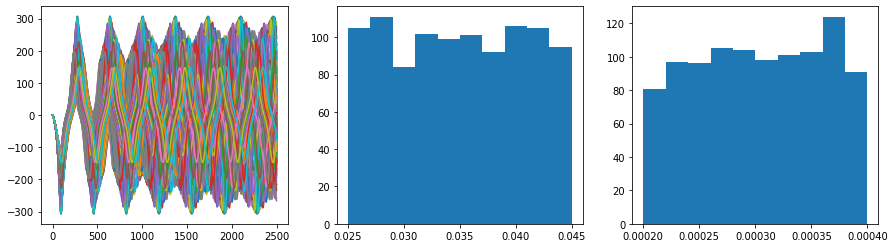

In [13]:
# Oscilator example
import numpy as np
from math import sqrt
from scipy.special import erf


def _generate_observations(K):

    x = _evaluate(omega=3.5e-2, lmbda=3e-4, K=K)
    rng = np.random.default_rng(12345)
    nobs = 50
    obs_points = np.linspace(0, K, nobs, endpoint=False, dtype=int)

    obs_with_std = np.zeros(shape=(len(obs_points), 2))

    for obs_idx, obs_point in enumerate(obs_points):
        # Set observation error's standard deviation to some
        # percentage of the amplitude of x with a minimum of, e.g., 1.
        obs_std = max(1, 0.02 * abs(x[obs_point]))
        obs_with_std[obs_idx, 0] = x[obs_point] + rng.normal(loc=0.0, scale=obs_std)
        obs_with_std[obs_idx, 1] = obs_std
    return obs_with_std, obs_points


def _evaluate(omega, lmbda, K):
    x = np.zeros(K)
    x[0] = 0
    x[1] = 1

    # Looping from 2 because we have initial conditions at k=0 and k=1.
    for k in range(2, K - 1):
        M = np.array([[2 + omega**2 - lmbda**2 * x[k] ** 2, -1], [1, 0]])
        u = np.array([x[k], x[k - 1]])
        u = M @ u
        x[k + 1] = u[0]
        x[k] = u[1]

    return x


def uniform(x, min_x, max_x):
    y = 0.5 * (1 + erf(x / sqrt(2.0)))
    return y * (max_x - min_x) + min_x


def forward_model(A, prior, response_x_axis):
    responses = []
    for [omega, lmbda] in A.T:
        r = _evaluate(
            omega=uniform(omega, *prior[0]),
            lmbda=uniform(lmbda, *prior[1]),
            K=len(response_x_axis),
        )
        responses.append(r)
    return np.array(responses).T


response_x_axis = range(2500)
realizations = 100

observations, observation_x_axis = _generate_observations(len(response_x_axis))
observation_values = observations[:, 0]
observation_errors = observations[:, 1]

A = np.asfortranarray(np.random.normal(0, 1, size=(2, realizations)))

priors = [(2.5e-2, 4.5e-2), (2.0e-4, 4.0e-4)]
plot_result(A, response_x_axis, uniform, priors, True)

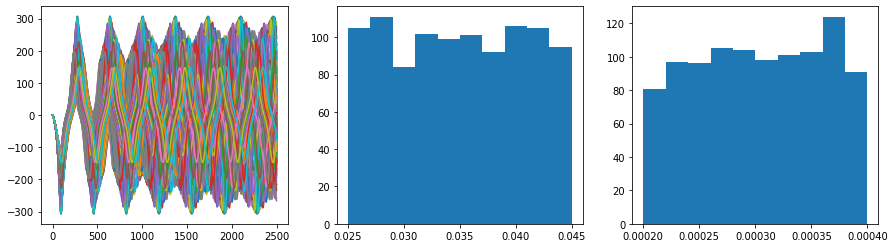

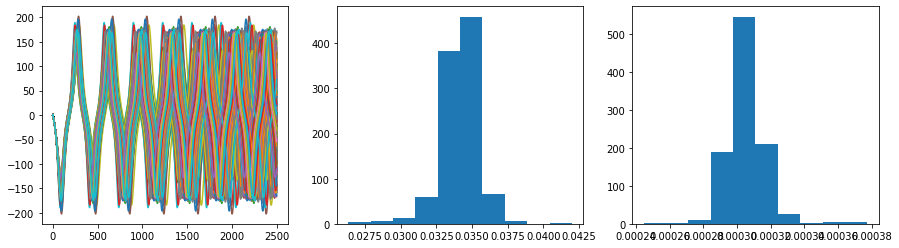

CPU times: user 48.4 s, sys: 696 ms, total: 49.1 s
Wall time: 48.1 s


In [14]:
import numpy as np
from matplotlib import pyplot as plt
from ert.analysis import ies


def ensemble_smoother():
    plot_result(A, response_x_axis, uniform, priors, True)
    responses_before = forward_model(A, priors, response_x_axis)
    S = responses_before[observation_x_axis]
    noise = np.random.rand(*S.shape)
    E = ies.make_E(observation_errors, noise)
    R = np.identity(len(observation_errors))
    D = ies.make_D(observation_values, E, S)
    D = (D.T / observation_errors).T
    E = (E.T / observation_errors).T
    S = (S.T / observation_errors).T

    X = ies.make_X(S, R, E, D)
    new_A = A @ X

    plot_result(new_A, response_x_axis, uniform, priors, True)


ensemble_smoother()

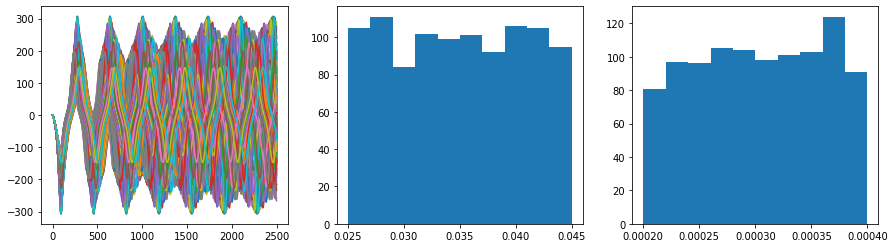

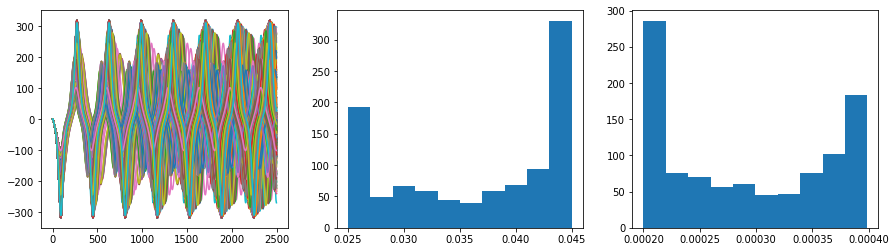

CPU times: user 47.4 s, sys: 263 ms, total: 47.7 s
Wall time: 47.4 s


In [16]:
import numpy as np
from matplotlib import pyplot as plt
from ert.analysis import ies


def iterative_smoother():
    A_current = np.copy(A)
    iterations = 1
    obs_mask = [True for _ in observation_values]
    ens_mask = [True for _ in range(realizations)]
    module_data = ies.ModuleData(realizations)
    module_config = ies.Config(True)

    for i in range(iterations):

        plot_result(A_current, response_x_axis, uniform, priors, True)
        responses_before = forward_model(A_current, priors, response_x_axis)
        S = responses_before[observation_x_axis]
        noise = np.random.rand(*S.shape)
        E = ies.make_E(observation_errors, noise)
        R = np.identity(len(observation_errors))
        D = ies.make_D(observation_values, E, S)
        D = (D.T / observation_errors).T
        E = (E.T / observation_errors).T
        S = (S.T / observation_errors).T

        ies.init_update(module_data, ens_mask, obs_mask)
        iteration_nr = module_data.iteration_nr
        step_length = module_config.get_steplength(iteration_nr)
        ies.update_A(
            module_data,
            A_current,
            S,
            R,
            E,
            D,
            step_length=step_length,
        )
        module_data.iteration_nr += 1

    plot_result(A_current, response_x_axis, uniform, priors, True)


iterative_smoother()